In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import xgi
import torch
from sklearn.decomposition import PCA
from kmeans_pytorch import kmeans
import seaborn as sns

In [2]:
users = pd.read_json('babynamesDB_users.json')
# User features are num_comments_stored, num_groups, num_posts_stored
users['num_groups'] = [len(i) for i in users['groups']]
users = users[['_id', 'num_comments_stored', 'num_posts_stored','num_groups']]
#convert users id to integer index
user_data = users
user_data['id'] = user_data['_id'].astype('category').cat.codes
user_data = user_data[['num_comments_stored', 'num_posts_stored', 'num_groups']]
# convert pandas dataframe to torch tensor
users_tensor = torch.tensor(user_data.values)
# create embeddings for users and pass in users_tensor as input
user_embeddings = torch.nn.Embedding(len(user_data), 3)
user_embeddings.weight.data.copy_(users_tensor)


tensor([[552.,   8.,   6.],
        [ 31.,   4.,   3.],
        [ 62.,   0.,   1.],
        ...,
        [  3.,   0.,   1.],
        [  4.,   3.,   2.],
        [  0.,   1.,   1.]])

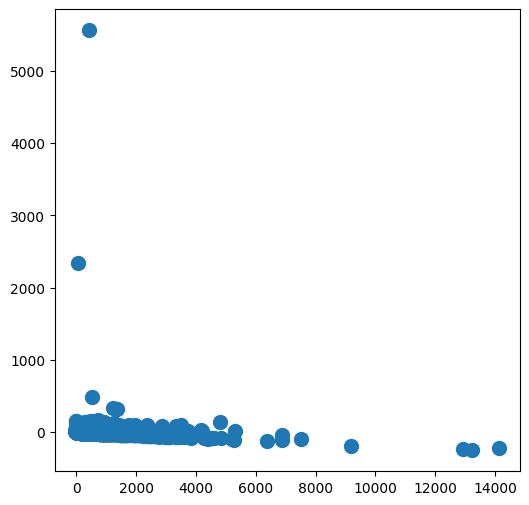

In [3]:
X = user_embeddings.weight.data.numpy()
pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(components[:, 0], components[:, 1], s=100)
plt.show()

running k-means on cpu..


[running kmeans]: 48it [00:01, 41.27it/s, center_shift=0.000000, iteration=48, tol=0.000100]    


tensor([[6.4551e+02, 2.4115e+01, 6.7532e+00],
        [3.7485e+03, 4.3430e+01, 1.1116e+01],
        [1.0478e+01, 1.4761e+00, 1.5109e+00]])
[  2407     86 367428]


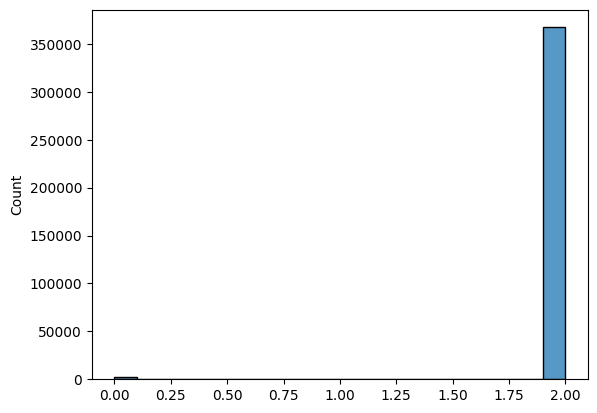

In [35]:
cluster_ids_x, cluster_centers = kmeans(X=users_tensor, num_clusters=3, distance='euclidean')
print(cluster_centers)
print(np.bincount(cluster_ids_x))

# histogram of 3 clusters
sns.histplot(cluster_ids_x)
plt.show()

running k-means on cpu..


[running kmeans]: 0it [00:00, ?it/s]

[running kmeans]: 21it [00:01, 17.42it/s, center_shift=0.000000, iteration=21, tol=0.000100]


tensor([[ 2.1719,  0.2362,  1.3036],
        [ 1.3334,  2.2443,  1.2279],
        [45.4037,  3.3530,  2.1361]])
[176282  78256 115383]


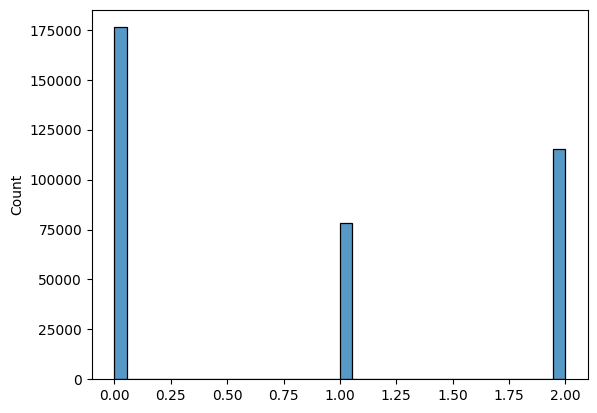

In [34]:
cluster_ids_x, cluster_centers = kmeans(X=users_tensor, num_clusters=3, distance='cosine')
print(cluster_centers)
print(np.bincount(cluster_ids_x))

# histogram of 3 clusters
sns.histplot(cluster_ids_x)
plt.show()

In [5]:
import torch.nn.functional as F

def euclidean_distance(x1, x2):
    """
    Compute the Euclidean distance between two vectors x1 and x2.
    """
    return torch.norm(x1.unsqueeze(0) - x2.unsqueeze(0)).item()

def cosine_similarity(x1, x2):
    """
    Compute cosine similarity between two vectors x1 and x2.
    """
    return F.cosine_similarity(x1.unsqueeze(0), x2.unsqueeze(0)).item()

def create_social_graph(embeddings, threshold, metric):
    """
    Create a social graph based on cosine similarity and a threshold.
    An edge is added between two nodes (users) if their cosine similarity is above the threshold.
    """
    num_users = embeddings.shape[0]
    social_graph = nx.Graph()
    
    for i in range(num_users):
        for j in range(i+1, num_users):  # Avoids duplicate checks and self-connections
            if metric == 'euclidean':
                similarity = euclidean_distance(embeddings[i], embeddings[j])
            elif metric == 'cosine':
                similarity = cosine_similarity(embeddings[i], embeddings[j])
            if similarity >= threshold:
                social_graph.add_edge(i, j)
                
    return social_graph


In [29]:
# subsample 1000 users from users_tensor
subsampled_users_tensor = users_tensor[:1000]
subsampled_users_tensor = subsampled_users_tensor.float()

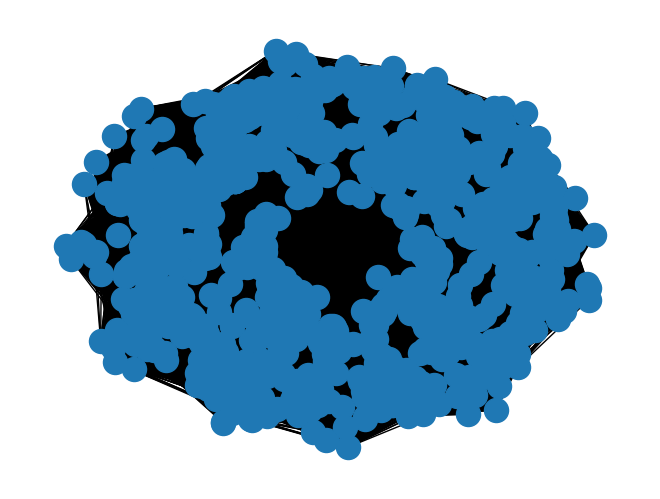

In [36]:
# create social graph
social_graph = create_social_graph(subsampled_users_tensor, threshold=0.9, metric='euclidean')
nx.draw(social_graph)

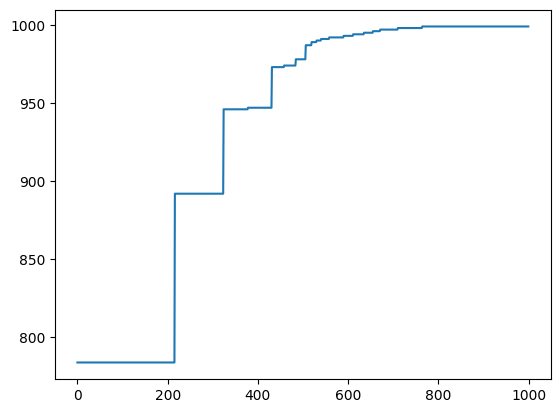

In [38]:
plt.plot(sorted(list(dict(social_graph.degree()).values())))

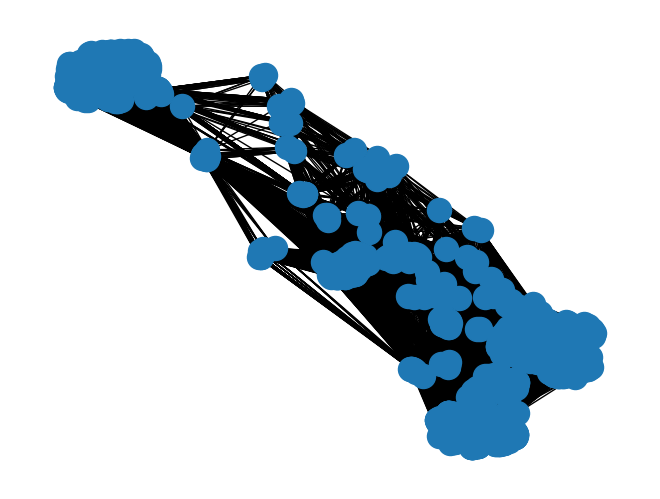

In [39]:
# create social graph
social_graph = create_social_graph(subsampled_users_tensor, threshold=0.9, metric='cosine')
nx.draw(social_graph)

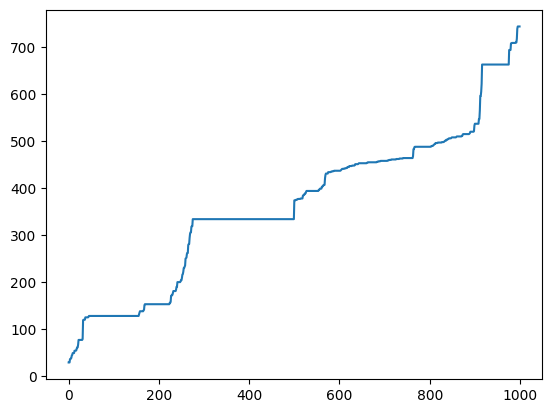

In [40]:
plt.plot(sorted(list(dict(social_graph.degree()).values())))